<a href="https://colab.research.google.com/github/EternalSorrrow/bak/blob/master/ra2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MURA Pre-train

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
mura_path = 'drive/My Drive/Work/ML/MURA/MURA-v1.1/'

In [3]:
!ls 'drive/My Drive/Work/ML/MURA/MURA-v1.1' ; echo '' ; head -5 'drive/My Drive/Work/ML/MURA/MURA-v1.1/train_image_paths.csv' ; echo ''
!head -5 'drive/My Drive/Work/ML/MURA/MURA-v1.1/train_labeled_studies.csv'; echo '' ; head -5 'drive/My Drive/Work/ML/MURA/MURA-v1.1/valid_image_paths.csv'
!echo '' ; head -240 'drive/My Drive/Work/ML/MURA/MURA-v1.1/valid_labeled_studies.csv' | tail -6
#!find . -name \*.png | wc -l
!cat  'drive/My Drive/Work/ML/MURA/MURA-v1.1/train_image_paths.csv' | wc -l
!cat  'drive/My Drive/Work/ML/MURA/MURA-v1.1/valid_image_paths.csv' | wc -l

train		       train_labeled_studies.csv  valid_image_paths.csv
train_image_paths.csv  valid			  valid_labeled_studies.csv

MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png

MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1

MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png
MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png
MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png
MURA-v1.1/valid/XR_WRIST/patient11185/st

In [4]:
#Encode study types by numbers

study_types = ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
study_type_codes = list(range(len(study_types)))
study_type_codes = dict(zip(study_types, study_type_codes))
study_type_codes

{'XR_ELBOW': 0,
 'XR_FINGER': 1,
 'XR_FOREARM': 2,
 'XR_HAND': 3,
 'XR_HUMERUS': 4,
 'XR_SHOULDER': 5,
 'XR_WRIST': 6}

In [5]:
#Encode study by tuple of study type, patient's id and study num 

import re

def encode_study_type(string):
  return study_type_codes[string]

def decode_study_type(num):
  for study_type, code in study_type_codes.items():
     if code == num:
       return study_type 

def extract_patient_id(string):
  return int(re.compile(r'patient(\d+)').findall(string)[0])

def extract_study_type(string):
  for study_type, code in study_type_codes.items():
    result = re.compile(study_type).findall(string)
    if result:
      return code

def extract_study_id(string):
  return int(re.compile(r'study(\d+)_').findall(string)[0])

def parse_study_desc(string):
  return (extract_study_type(string), extract_patient_id(string), extract_study_id(string))

def parse_label(string):
  return int(re.compile(r',(\d)').findall(string)[0])

with open(mura_path + 'valid_labeled_studies.csv', 'r') as f:
  line = f.readline()
  desc = parse_study_desc(line)
  print(line)
  print(desc)
  print(parse_label(line))
  print(decode_study_type(desc[0]))

MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1

(6, 11185, 1)
1
XR_WRIST


In [0]:
#Extract some info about the dataset to visualize it's statistics

import pandas as pd
import os


def count_images(filename):
  counter = dict()
  
  with open(mura_path + filename, 'r') as file:
    lines = file.read().replace('MURA-v1.1/', '').split('\n')[:-1]
  
  for line in lines:
    desc = parse_study_desc(line)
    if desc not in counter.keys():
      counter[desc] = 1
    else:
      counter[desc] += 1
  
  return counter

def parse_study_metadata(filename, file_counts, verbose = False):
  metadata = pd.DataFrame(columns=['Category', 'Patient', 'Study', 'Images', 'Label'])

  with open(mura_path + filename, 'r') as file:
    lines = file.read().replace('MURA-v1.1/', '').split('\n')[:-1]
  
  linecount = len(lines)

  for i, line in enumerate(lines):
    category, patient, study = parse_study_desc(line)
    label = parse_label(line)
    line = line.split(',')[0]
    images = file_counts[(category, patient, study)]
    metadata.loc[i] = [category, patient, study, images, label]

    if (i + 1) % 1000 == 0:
      print('Read', i+1, 'items from', linecount)

  return metadata

In [7]:
train_metadata = parse_study_metadata('train_labeled_studies.csv', count_images('train_image_paths.csv'), True)
train_metadata.head()

Read 1000 items from 13457
Read 2000 items from 13457
Read 3000 items from 13457
Read 4000 items from 13457
Read 5000 items from 13457
Read 6000 items from 13457
Read 7000 items from 13457
Read 8000 items from 13457
Read 9000 items from 13457
Read 10000 items from 13457
Read 11000 items from 13457
Read 12000 items from 13457
Read 13000 items from 13457


,Category,Patient,Study,Images,Label
0,5,1,1,3,1
1,5,2,1,3,1
2,5,3,1,3,1
3,5,4,1,4,1
4,5,5,1,1,1


In [9]:
val_metadata = parse_study_metadata('valid_labeled_studies.csv', count_images('valid_image_paths.csv'), True)
val_metadata.head()

Read 1000 items from 1199


,Category,Patient,Study,Images,Label
0,6,11185,1,4,1
1,6,11186,1,2,1
2,6,11186,2,3,1
3,6,11186,3,3,1
4,6,11187,1,1,1


In [0]:
#Different views on data definition

import matplotlib.pyplot as plt
import numpy as np

studies_train = train_metadata.groupby(by=['Category']).count()
studies_val = val_metadata.groupby(by=['Category']).count()

patients_train = train_metadata.groupby(by=['Category', 'Patient']).count().groupby(by=['Category']).count()
patients_val = val_metadata.groupby(by=['Category', 'Patient']).count().groupby(by=['Category']).count()

images_train = train_metadata.groupby(by=['Category'])['Images'].sum()
images_val = val_metadata.groupby(by=['Category'])['Images'].sum()

labels_studies_train = train_metadata.groupby(by=['Label']).count()
labels_images_train = train_metadata.groupby(by=['Label'])['Images'].sum()

labels_studies_val = val_metadata.groupby(by=['Label']).count()
labels_images_val = val_metadata.groupby(by=['Label'])['Images'].sum()

train_labels_per_study = dict()
val_labels_per_study = dict()

train_labels_per_study_imgs = dict()
val_labels_per_study_imgs = dict()

for _, study_code in study_type_codes.items():
  tr = train_metadata.loc[train_metadata['Category'] == study_code].groupby(by=['Label'])['Study'].count()
  vl = val_metadata.loc[val_metadata['Category'] == study_code].groupby(by=['Label'])['Study'].count()

  tr_im = train_metadata.loc[train_metadata['Category'] == study_code].groupby(by=['Label'])['Images'].sum()
  vl_im = val_metadata.loc[val_metadata['Category'] == study_code].groupby(by=['Label'])['Images'].sum()
  
  train_labels_per_study[study_code] = tr
  val_labels_per_study[study_code] = vl

  train_labels_per_study_imgs[study_code] = tr_im
  val_labels_per_study_imgs[study_code] = vl_im

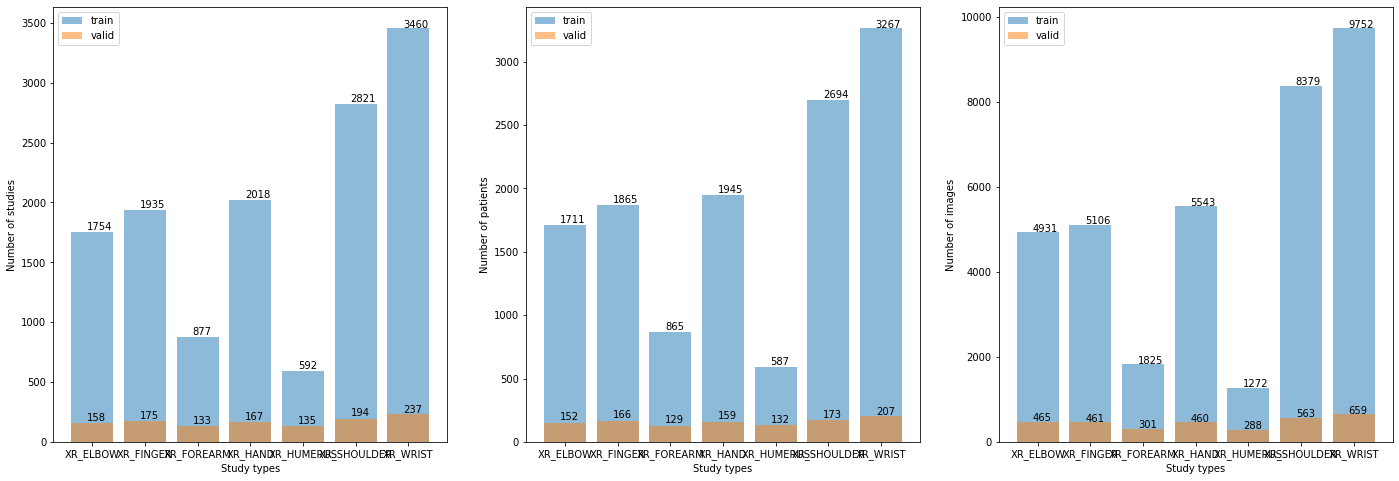

In [11]:
fig, ax = plt.subplots(figsize=(24, 8), ncols=3)

for i, phase in enumerate([studies_train, studies_val]):
    counts = phase[['Study']].values.ravel()
    m = max(counts)
    for i, v in enumerate(counts):
      if v==m: ax[0].text(i-0.1, v+3, str(v))
      else: ax[0].text(i-0.1, v + 20, str(v))
    x_pos = np.arange(len(study_types))
    ax[0].bar(x_pos, counts, alpha=0.5)
    ax[0].set_xticks(x_pos)
    ax[0].set_xticklabels(study_types)

for i, phase in enumerate([patients_train, patients_val]):
    counts = phase[['Study']].values.ravel()
    m = max(counts)
    for i, v in enumerate(counts):
      if v==m: ax[1].text(i-0.1, v+3, str(v))
      else: ax[1].text(i-0.1, v + 20, str(v))
    x_pos = np.arange(len(study_types))
    ax[1].bar(x_pos, counts, alpha=0.5)
    ax[1].set_xticks(x_pos)
    ax[1].set_xticklabels(study_types)

for i, phase in enumerate([images_train, images_val]):
    counts = phase.values.ravel()
    m = max(counts)
    for i, v in enumerate(counts):
      if v==m: ax[2].text(i-0.1, v+3, str(v))
      else: ax[2].text(i-0.1, v + 20, str(v))
    x_pos = np.arange(len(study_types))
    ax[2].bar(x_pos, counts, alpha=0.5)
    ax[2].set_xticks(x_pos)
    ax[2].set_xticklabels(study_types)

ax[0].set_xlabel('Study types')
ax[0].set_ylabel('Number of studies')
ax[0].legend(['train', 'valid'])

ax[1].set_xlabel('Study types')
ax[1].set_ylabel('Number of patients')
ax[1].legend(['train', 'valid'])

ax[2].set_xlabel('Study types')
ax[2].set_ylabel('Number of images')
ax[2].legend(['train', 'valid'])

plt.show()

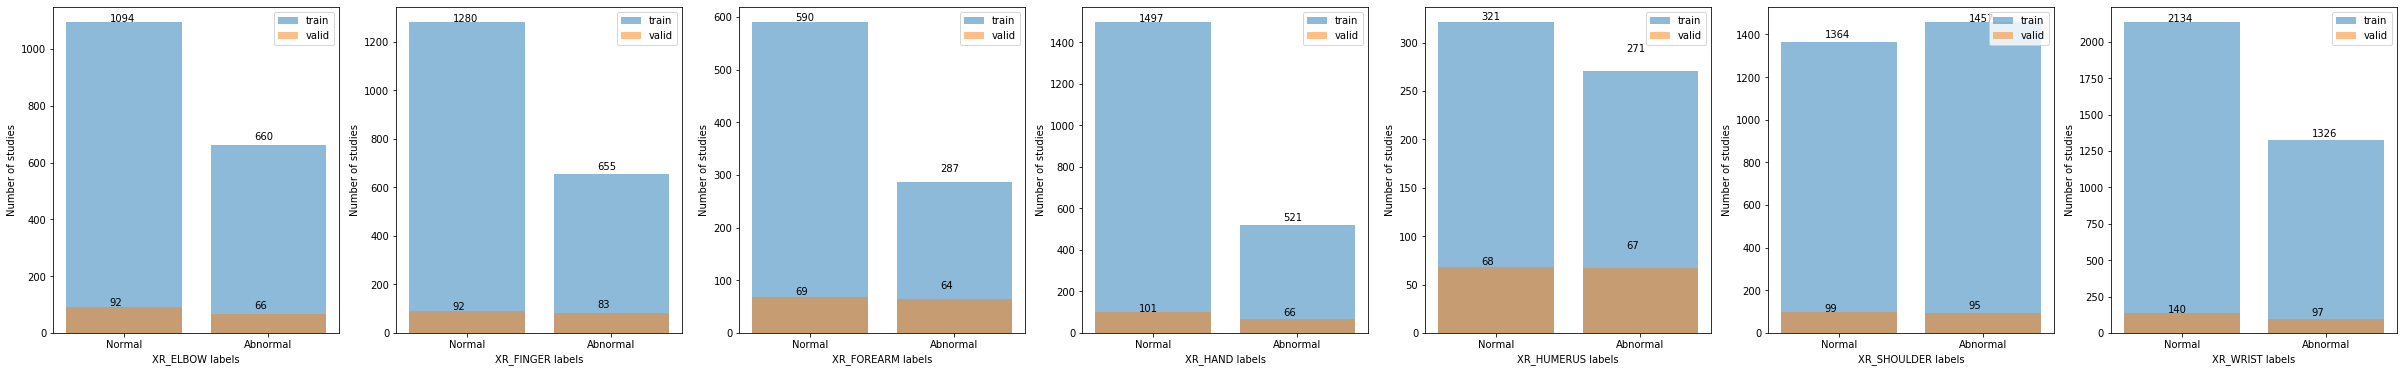

In [12]:
fig, ax = plt.subplots(figsize=(6 * len(study_types), 6), ncols=len(study_types))
label_values = ['Normal', 'Abnormal']

for y in range(len(study_types)):
    for i, phase in enumerate([train_labels_per_study[y], val_labels_per_study[y]]):
      counts = phase.values.ravel()
      m = max(counts)
      for i, v in enumerate(counts):
        if v==m: ax[y].text(i-0.1, v+3, str(v))
        else: ax[y].text(i-0.1, v + 20, str(v))
      x_pos = np.arange(2)

      ax[y].bar(x_pos, counts, alpha=0.5)
      ax[y].set_xticks(x_pos)
      ax[y].set_xticklabels(label_values)

      ax[y].set_xlabel(study_types[y] + ' labels')
      ax[y].set_ylabel('Number of studies')
      ax[y].legend(['train', 'valid'])


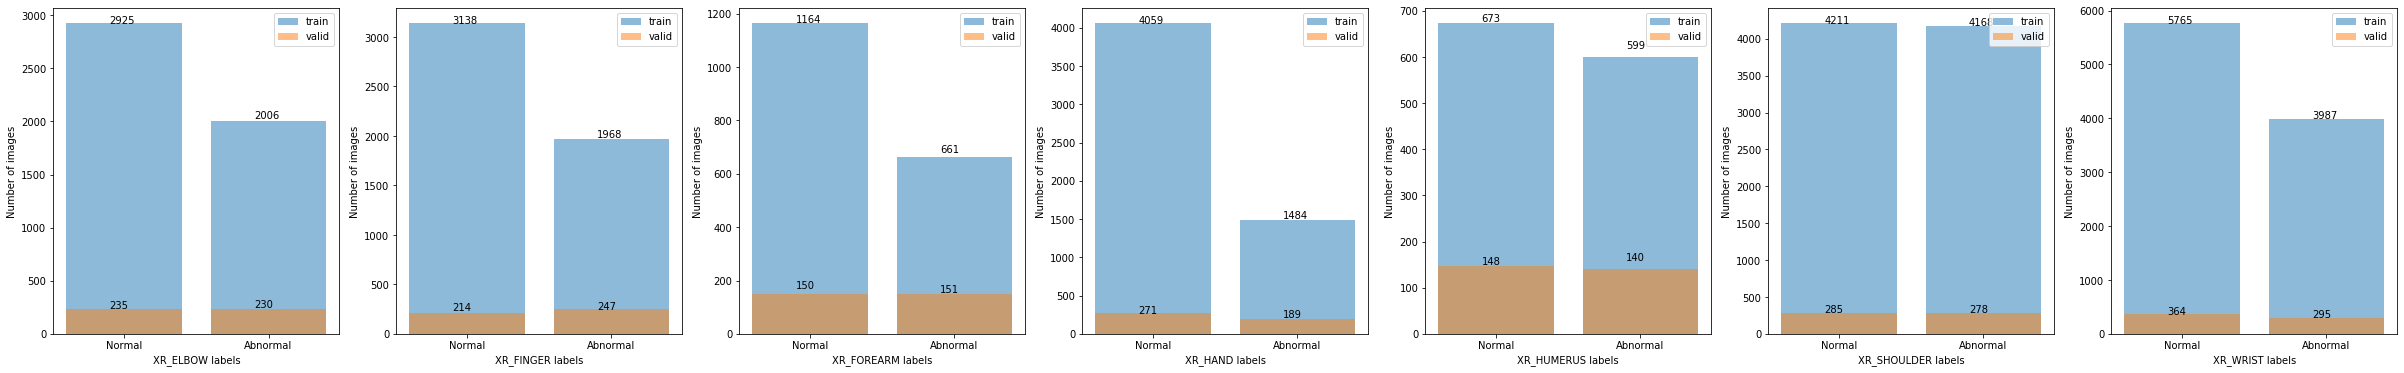

In [13]:
fig, ax = plt.subplots(figsize=(6 * len(study_types), 6), ncols=len(study_types))
label_values = ['Normal', 'Abnormal']

for y in range(len(study_types)):
    for i, phase in enumerate([train_labels_per_study_imgs[y], val_labels_per_study_imgs[y]]):
      counts = phase.values.ravel()
      m = max(counts)
      for i, v in enumerate(counts):
        if v==m: ax[y].text(i-0.1, v+3, str(v))
        else: ax[y].text(i-0.1, v + 20, str(v))
      x_pos = np.arange(2)

      ax[y].bar(x_pos, counts, alpha=0.5)
      ax[y].set_xticks(x_pos)
      ax[y].set_xticklabels(label_values)

      ax[y].set_xlabel(study_types[y] + ' labels')
      ax[y].set_ylabel('Number of images')
      ax[y].legend(['train', 'valid'])


In [0]:
input_size = (320, 320)
n_classes = 2

In [18]:
#Get image paths

train_paths, val_paths = [], []

with open(mura_path + 'train_image_paths.csv', 'r') as file:
  train_paths = file.read().replace('MURA-v1.1/', '').split('\n')[:-1]

with open(mura_path + 'valid_image_paths.csv', 'r') as file:
  val_paths = file.read().replace('MURA-v1.1/', '').split('\n')[:-1]

print(len(train_paths), len(val_paths))

36808 3197


In [19]:
#Sort them by study type

def separate_paths(paths):  
  sep_paths = dict()
  for study_type in study_types:
    sep_paths[study_type] = []

  for path in paths:
    for study_type in study_types:
      if study_type in path:
        sep_paths[study_type].append(path)

  return sep_paths

train_paths = separate_paths(train_paths)
val_paths = separate_paths(val_paths)

print([len(array) for key, array in train_paths.items()])
print([len(array) for key, array in val_paths.items()])

[4931, 5106, 1825, 5543, 1272, 8379, 9752]
[465, 461, 301, 460, 288, 563, 659]


In [20]:
train_label_paths, val_label_paths = [], []

with open(mura_path + 'train_labeled_studies.csv', 'r') as file:
  train_label_paths = file.read().split('\n')[:-1]

with open(mura_path + 'valid_labeled_studies.csv', 'r') as file:
  val_label_paths = file.read().split('\n')[:-1]

train_label_paths = separate_paths(train_label_paths)
val_label_paths = separate_paths(val_label_paths)

print([len(array) for key, array in train_label_paths.items()])
print([len(array) for key, array in val_label_paths.items()])

[1754, 1935, 877, 2018, 592, 2821, 3460]
[158, 175, 133, 167, 135, 194, 237]


In [21]:
#Get labels for studies

def extract_labels(paths):
  return list(map(parse_label, paths))

def extract_descs(paths):
  return list(map(parse_study_desc, paths))

def get_labels_dict(path_dict):
  labels_dict = dict()
  for study_type in study_types:
    labels_dict[study_type] = dict()

  for study_type, paths in path_dict.items():
    labels_dict[study_type] = dict(list(zip(extract_descs(paths), extract_labels(paths))))
  return labels_dict

train_labels = get_labels_dict(train_label_paths)
val_labels = get_labels_dict(val_label_paths)

print([len(array) for key, array in train_labels.items()])
print([len(array) for key, array in val_labels.items()])

[1754, 1935, 877, 2018, 592, 2821, 3460]
[158, 175, 133, 167, 135, 194, 237]


In [0]:
#Read images from drive

import cv2

def read_images(paths, image_size=input_size, mono=False, verb_step = 200, read_first=-1):
  interpolation = cv2.INTER_AREA
  imgs = []

  print('Starting reading...')
  if read_first > 0:
    paths = paths[:read_first]

  for i, path in enumerate(paths):
    img = cv2.imread(mura_path + path)
    if img is None:
      print('None image on path:', mura_path + path)
    
    else:
      if mono:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img = cv2.resize(img, dsize=image_size, interpolation=interpolation)
      desc = parse_study_desc(path)
      imgs.append((desc, img))
    
    if (i + 1) % verb_step == 0:
      print('Read', i, 'images from', len(paths))
  
  return imgs


In [0]:
#Combine functions defined above to load data with one function

def read_category_data(category, read_first=-1):
  train_raw = read_images(train_paths[category], read_first=read_first)
  valid_raw = read_images(val_paths[category], read_first=read_first)

  t_imgs = np.array(list(map(lambda x: x[1], train_raw)))
  t_labels = np.array(list(map(lambda x: train_labels[category][x[0]], train_raw)))

  v_imgs = np.array(list(map(lambda x: x[1], valid_raw)))
  v_labels = np.array(list(map(lambda x: val_labels[category][x[0]], valid_raw)))

  return t_imgs, t_labels, v_imgs, v_labels

In [0]:
#Export data to hdf5 to speed loading up

import numpy as np
import h5py

export_folder = 'drive/My Drive/Work/ML/RA2/'

def export_to_hdf5(train_data, train_labels, valid_data, valid_labels, output_filename, data_order='tf'):
  #data_order = 'th' for Theano, 'tf' for Tensorflow
  # check the order of data and chose proper data shape to save images

  if data_order == 'th':
      train_shape = (train_data.shape[0], train_data.shape[3], train_data.shape[1], train_data.shape[2])
      val_shape = (valid_data.shape[0], valid_data.shape[3], valid_data.shape[1], valid_data.shape[2])
  elif data_order == 'tf':
      train_shape = (train_data.shape)
      val_shape = (valid_data.shape)

  # open a hdf5 file and create earrays
  with h5py.File(output_filename+'.hdf5', mode='w') as hdf5_file:
    
    hdf5_file.create_dataset("train_img", train_shape, np.uint8)
    hdf5_file.create_dataset("val_img", val_shape, np.uint8)
    hdf5_file.create_dataset("train_labels", (len(train_labels),), np.int8)
    hdf5_file.create_dataset("val_labels", (len(valid_labels),), np.int8)


    hdf5_file["train_labels"][...] = train_labels
    hdf5_file["val_labels"][...] = valid_labels

    for i in range(len(train_data)):
        if i % 200 == 0 and i > 1:
            print('Train data: {}/{}'.format(i, len(train_data)))
        img = train_data[i]
        
        # if the data order is Theano, axis orders should change
        if data_order == 'th':
            img = np.rollaxis(img, 2)
        # save the image and calculate the mean so far
        hdf5_file["train_img"][i, :, :, :] = img
        
    for i in range(len(valid_data)):
        # print how many images are saved every 1000 images
        if i % 200 == 0 and i > 1:
            print('Validation data: {}/{}'.format(i, len(valid_data)))
        img = valid_data[i]
        
        # if the data order is Theano, axis orders should change
        if data_order == 'th':
            img = np.rollaxis(img, 2)
        # save the image
        hdf5_file["val_img"][i, :, :, :] = img
    

In [0]:
def import_from_hdf5(path):
  with h5py.File(path, "r", driver='core') as hdf5_file:

    train_data = None
    batch_begin, batch_end = 0, 200
    train_samples = len(hdf5_file['train_img'])
    while True:
      batch_end = min(batch_end, train_samples)
      batch = hdf5_file['train_img'][batch_begin:batch_end, :, :, :]
      if train_data is None:
        train_data = batch
      else:
        train_data = np.concatenate([train_data, batch], axis=0)
      print('Loaded', batch_end, 'samples of', train_samples, 'samples of train data')
      if batch_end == train_samples:
        break
      else:
        batch_begin = batch_end
        batch_end += 200

    train_labels = hdf5_file['train_labels'][:]
    
    valid_data = None
    batch_begin, batch_end = 0, 200
    val_samples = len(hdf5_file['val_img'])
    while True:
      batch_end = min(batch_end, val_samples)
      batch = hdf5_file['val_img'][batch_begin:batch_end, :, :, :]
      if valid_data is None:
        valid_data = batch
      else:
        valid_data = np.concatenate([valid_data, batch], axis=0)
      print('Loaded', batch_end, 'samples of', val_samples, 'samples of val data')
      if batch_end == val_samples:
        break
      else:
        batch_begin = batch_end
        batch_end += 200
    
    valid_labels = hdf5_file['val_labels'][:]

    train_data, valid_data = train_data[:, :, :, :], valid_data[:, :, :, :]
    
  return train_data, train_labels, valid_data, valid_labels

In [0]:
#hand_train, hand_train_labels, hand_valid, hand_valid_labels = read_category_data('XR_HAND')

In [0]:
#print(hand_train.shape, hand_train_labels.shape, hand_valid.shape, hand_valid_labels.shape)

#export_to_hdf5(hand_train, hand_train_labels, hand_valid, hand_valid_labels, export_folder + 'hand')

In [28]:
hand_train, hand_train_labels, hand_valid, hand_valid_labels = import_from_hdf5(export_folder + 'hand.hdf5')

print(hand_train.shape, hand_train_labels.shape, hand_valid.shape, hand_valid_labels.shape)

Loaded 200 samples of 5543 samples of train data
Loaded 400 samples of 5543 samples of train data
Loaded 600 samples of 5543 samples of train data
Loaded 800 samples of 5543 samples of train data
Loaded 1000 samples of 5543 samples of train data
Loaded 1200 samples of 5543 samples of train data
Loaded 1400 samples of 5543 samples of train data
Loaded 1600 samples of 5543 samples of train data
Loaded 1800 samples of 5543 samples of train data
Loaded 2000 samples of 5543 samples of train data
Loaded 2200 samples of 5543 samples of train data
Loaded 2400 samples of 5543 samples of train data
Loaded 2600 samples of 5543 samples of train data
Loaded 2800 samples of 5543 samples of train data
Loaded 3000 samples of 5543 samples of train data
Loaded 3200 samples of 5543 samples of train data
Loaded 3400 samples of 5543 samples of train data
Loaded 3600 samples of 5543 samples of train data
Loaded 3800 samples of 5543 samples of train data
Loaded 4000 samples of 5543 samples of train data
Load

1 1 1 1 
1 1 1 1 


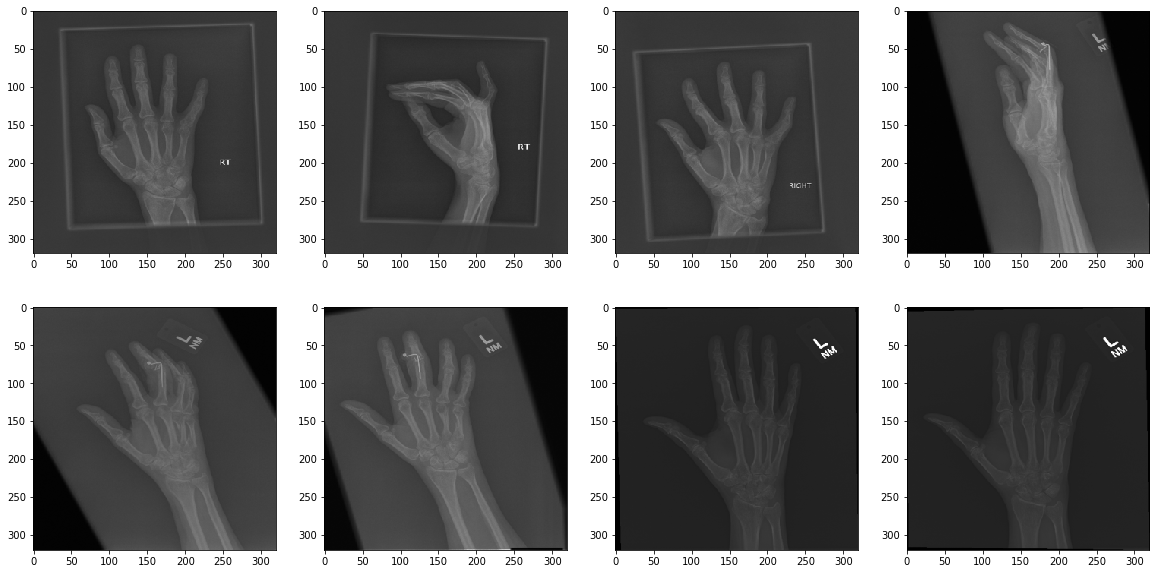

In [29]:
fig, ax = plt.subplots(figsize=(20, 10), ncols=4, nrows=2)

for i in range(2):
  s = ''
  for k in range(4):
    
    ax[i, k].imshow(hand_train[i * 4 + k].astype(np.uint8))
    s += str(hand_train_labels[i * 4 + k]) + ' '
  print(s)

plt.show()

In [0]:
#Define functions for standardization

def get_mean_and_std(data): #NumPy realization is memory-wasting
  
  sum_acc = 0
  for item in data:
    sum_acc += np.sum(item, axis=(0, 1, 2))
  mean = sum_acc / data.size

  std_acc = 0
  for item in data:
    diff = item - mean
    std_acc += np.sum(diff * diff, axis=(0,1,2))
  std = np.sqrt(std_acc / data.size)

  return mean, std


def standardize(data, batch_size=64): #Batch-processing version
  print('Calculating mean and std...')
  mean, std = get_mean_and_std(data)

  std_data = None
  print('Batch processing:')
  batch_begin, batch_end = 0, batch_size
  while True:
    batch_end = min(batch_end, len(data))
    batch = data[batch_begin:batch_end].astype(np.float32)
    batch = (batch - mean) / std
    if std_data is None:
      std_data = batch
    else:
      std_data = np.concatenate([std_data, batch], axis=0)
    print('Processed', len(std_data), 'samples of', len(data))

    if batch_end == len(data):
      break
    else:
      batch_end += batch_size
  return std_data


#Will not use, still it doesn't fit into memory, will be using built-in Keras functionality itself

#hand_t_std, hand_v_std = standardize(hand_train), standardize(hand_valid)
#print(hand_t_std.mean(), hand_t_std.std(), hand_v_std.mean(), hand_v_std.std())
#print(hand_t_std.shape(), hand_v_std.shape())

In [0]:
#Model definition

from keras.applications.densenet import DenseNet121
from keras.layers import Dense
from keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from keras.optimizers import adam

def get_compiled_model_instance(lr=0.001, beta1=0.9, beta2=0.999, label_smoothing=0.0):

  def loss(y_true, y_pred): #Wrapping a tf loss to the keras interface with only 2 args
    return binary_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)

  
  base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=None, pooling='avg')

  x = base_model.output
  predictions = Dense(n_classes, activation='sigmoid')(x)

  optimizer = adam(lr=lr, beta_1=beta1, beta_2=beta2)


  model = Model(inputs=base_model.input, outputs=predictions)
  model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

  return model

#get_compiled_model_instance()

In [0]:
#Data generators

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    featurewise_center = True, #Mean-shift
    featurewise_std_normalization = True, #Standardization
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    #width_shift_range=0.2,
    #height_shift_range=0.2
    )

train_datagen.fit(hand_train)

valid_datagen = ImageDataGenerator()

In [0]:
#Learning rate scheduler - reduce by factor 0.1 on plateau longer than 10 epochs

from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_delta=0.0001, verbose=1, min_lr=0.0000001)

In [36]:
#Class weights computing to penalize errors on more rare class

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(hand_train_labels), hand_train_labels)

class_weights

array([0.68280365, 1.8675876 ])

In [0]:
#Loss plotting
#https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

#Modified to plot losses at batch level - work in progress

from IPython.display import clear_output

from keras.callbacks import Callback

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.epoch = 0
        self.x_batch = []
        self.x_epoch = []

        self.losses_batch = []
        self.val_losses_batch = []

        self.losses_epoch = []
        self.val_losses_epoch = []
        
        self.fig, self.ax = plt.subplots(figsize=(16, 8), ncols=2)
        
        self.logs = dict()

    def on_batch_end(self, batch, logs={}):
      #self.logs[(self.epoch, batch)] = logs
      self.x_batch.append(batch)

      self.losses_batch.append(logs.get('loss'))
      self.val_losses_batch.append(logs.get('val_loss'))

      clear_output(wait=True)
      
      ax[0].plot(self.x_batch, self.losses_batch, label="loss_batch")
      ax[0].plot(self.x_batch, self.val_losses_batch, label="val_loss_batch")
      ax[0].legend()
      
      ax[1].plot(self.x_epoch, self.losses_epoch, label="loss_epoch")
      ax[1].plot(self.x_epoch, self.val_losses_epoch, label="val_loss_epoch")
      ax[1].legend()
      plt.show();
      

    def on_epoch_begin(self, epoch, logs={}):
      self.epoch = epoch

      self.x_batch = []
      self.losses_batch = []
      self.val_losses_batch = []

    def on_epoch_end(self, epoch, logs={}):
      
      self.logs[(self.epoch, -1)] = logs
      self.x_epoch.append(epoch)
      self.losses_epoch.append(logs.get('loss'))
      self.val_losses_epoch.append(logs.get('val_loss'))
      
      clear_output(wait=True)
      
      ax[0].plot(self.x_batch, self.losses_batch, label="loss_batch")
      ax[0].plot(self.x_batch, self.val_losses_batch, label="val_loss_batch")
      ax[0].legend()
      
      ax[1].plot(self.x_epoch, self.losses_epoch, label="loss_epoch")
      ax[1].plot(self.x_epoch, self.val_losses_epoch, label="val_loss_epoch")
      ax[1].legend()
      plt.show();
        
plot_losses = PlotLosses()

In [0]:
#Using TensorBoard as an advanced tool to watch the learning process
#Learning in progress

#%load_ext tensorboard.notebook

#from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

#tbc=TensorBoardColab()

In [0]:
callbacks = [reduce_lr, plot_losses]#, TensorBoardColabCallback(tbc)]

In [44]:
hand_model_of = get_compiled_model_instance(lr=0.01)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [45]:
#Sanity check - overfit the model on small subset of data

batch_size = 16 #Should be small enough dataset to achieve 1.0 accuracy
epochs = 100

of_set_size = 16

hand_model_of.fit(x=hand_train[:of_set_size, :, :, :], y=hand_train_labels[:of_set_size], epochs = epochs, batch_size=batch_size)



Epoch 1/100
16/16 [==============================] - 25s 2s/step - loss: 0.5745 - acc: 1.0000
Epoch 2/100
16/16 [==============================] - 4s 277ms/step - loss: 0.0204 - acc: 0.8125
Epoch 3/100
16/16 [==============================] - 5s 282ms/step - loss: 9.5405e-04 - acc: 0.5625
Epoch 4/100
16/16 [==============================] - 5s 326ms/step - loss: 2.0965e-05 - acc: 0.4375
Epoch 5/100
16/16 [==============================] - 5s 294ms/step - loss: 5.1902e-06 - acc: 0.3750
Epoch 6/100
16/16 [==============================] - 5s 291ms/step - loss: 1.7251e-06 - acc: 0.3750
Epoch 7/100
16/16 [==============================] - 5s 285ms/step - loss: 6.8828e-07 - acc: 0.2500
Epoch 8/100
16/16 [==============================] - 5s 296ms/step - loss: 3.0303e-07 - acc: 0.2500
Epoch 9/100
16/16 [==============================] - 5s 291ms/step - loss: 1.4592e-07 - acc: 0.2500
Epoch 10/100
16/16 [==============================] - 5s 287ms/step - loss: 7.5812e-08 - acc: 0.2500
Epoch 1

In [0]:
hand_model = get_compiled_model_instance()

In [0]:
#Launch primary model training

batch_size = 8
epochs = 50

hand_model.fit_generator(train_datagen.flow(hand_train, hand_train_labels, batch_size=batch_size),
                         validation_data=valid_datagen.flow(hand_valid, hand_valid_labels, batch_size=batch_size),
                         epochs=epochs,
                         callbacks=callbacks)

KeyboardInterrupt: ignored

In [0]:
#@title
!ls 'drive/My Drive/Work/ML/RA2/ra2'

In [0]:
#@title
import pandas as pd 

data = pd.read_csv('drive/My Drive/Work/ML/RA2/ra2/Subset_training.csv')
data.head()

In [0]:
#@title
import os
import cv2

ra2_path = 'drive/My Drive/Work/ML/RA2/ra2/'
imgs = []

files = sorted(os.listdir(ra2_path + 'Subset_Training'))
print(files)

for file in files:
  imgs.append((file, cv2.imread(ra2_path + 'Subset_Training/' + file)))

import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.imshow(imgs[0][1], cmap = plt.cm.gray)

In [0]:
#@title
import numpy as np

img = imgs[0][1]

#Sum of the cross-differences between all 3 pairs of channels to determine, can we use a grayscale image without substantional information loss
diff_map = np.abs(img[:,:,0]-img[:, :, 1])+np.abs(img[:,:,0]-img[:, :, 2]) + np.abs(img[:,:,1]-img[:,:,2])

print(np.mean(diff_map), np.var(diff_map))#All 3 channels are the same, we can reduce the input tensor size 3x by using the grayscale image